In [ ]:
volume_path = 'data/NODDI_DWI.nii/NODDI_DWI.nii'
mask_path = 'data/BRAIN_MASK.nii/BRAIN_MASK.nii'
scheme_path = 'data/NODDI_DWI.scheme'

# Inicialización de Python

Se puede omitir esta sección para revisión.

## Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'from timeit import default_timer as timer\nstart = timer()\n_ = 0\nend = timer()\nprint(end - start)'

In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/imagenes_biomedicas/")

## Instalación de Paquetes Necesarios

In [ ]:
!pip install nibabel dipy fury pytest nose

# Clase TensorModel

Objeto inspirado en `TensorModel` de la librería `dti` que tiene como parámetros iniciales los vectores unitarios $g_i$ y las magnitudes $b_i$ del experimento.

Dado un conjunto de volumenes de RM ponderado en difusion de hidrógeno, correspondientes a los vectores del experimento, ajusta un tensor de difusión __Gaussiano__ en cada voxel mediante mínimos cuadrádos y calcula los eigenpares de la matriz indicida por este vector de difusión usando la factorización SVD de la matriz.

In [ ]:
from dipy.core.gradients import gradient_table 
import numpy as np
import scipy

import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

class TensorModel():

    def __init__(self, bvals, bvecs, many_magnitudes=False, index_magnitude=1):
        
        self.gtab = gradient_table(bvals, bvecs)

        # Lista de diferentes magnitudes
        self.b_list = np.unique(bvals)

        # Indices de imagenes S_0
        self.s_zero_indices = (bvals == self.b_list[0])
        # Indices de imagenes S_i para primera magnitud b
        self.volume_indices = [_ for _ in range(bvals.shape[0])]
        if not many_magnitudes:
            self.volume_indices = (bvals == self.b_list[index_magnitude])

        #print(self.b_list)
        #print(bvals)
        #print(self.volume_indices)
        #print(self.s_zero_indices)

    def get_S_i_volume(self, data):
        # Imagenes S_i
        S_i = data[:,:,:, :,  self.volume_indices]
        return np.array(S_i, dtype=np.float64)

    def get_s_0_mean(self, data):
        # Imagenes S_0
        s_0_volume = data[:,:,:, :,  self.s_zero_indices]
        # Volumen S_0 promedio enmascarado
        S_0 = s_0_volume.transpose()
        S_0 = S_0.sum(axis=0).transpose()

        #sli = S_0.shape[2] // 2

        #plt.figure('Brain segmentation')
        #plt.subplot(1, 1, 1).set_axis_off()
        #plt.imshow(histeq(S_0[:,:,sli,0].astype('float')).T,
        #        cmap='gray', origin='lower')

        return np.array(S_0, dtype=np.float64)

    def fit(self, data):
        
        # S_0 promedio y S_i's
        S_0 = self.get_s_0_mean(data)
        S = self.get_S_i_volume(data)

        # Vectores g_i y magnitudes b_i
        bvecs = self.gtab.bvecs[self.volume_indices,:]
        bvals = self.gtab.bvals[self.volume_indices]
        
        #print("S shape, S_0 shape, bvals shape")
        #print(S.shape, S_0.shape, bvals.shape, bvecs.shape)

        S_0 = S_0.transpose()
        S = S.transpose()

        #print("S shape, S_0 shape, bvals shape")
        #print(S.shape, S_0.shape, bvals.shape, bvecs.shape)
        
        S_0_mask = (S_0 > 0.0)
        #print(np.sum(S_0_mask))
        quotient = np.divide(S, S_0, where=S_0_mask).transpose()
        
        #print("Quotient shape : ")
        #print(quotient.shape)

        quotient_mask = (quotient>0.0)
        log_quotient = np.log(quotient, where=quotient_mask)

        #print("LogQuotient shape : ")
        #print(log_quotient.shape)
        #print(bvals.shape)

        bvals_mask = (bvals > 0.0)
        #print(np.sum(log_quotient > 0.0))
        S_hat = - np.divide(log_quotient, bvals, where=bvals_mask)
        
        #print("S_hat shape")
        #print(S_hat.shape)
        #print(bvecs.shape)
        # Cada fila i es G_i^T
        G = np.column_stack((
            bvecs[:,0] ** 2,
            2 * bvecs[:,0] * bvecs[:,1],
            2 * bvecs[:,0] * bvecs[:,2],
            bvecs[:,1] ** 2,
            2 * bvecs[:,1] * bvecs[:,2],
            bvecs[:,2] ** 2
        ))
        #print("G shape")
        #print(G.shape)

        G_hat = G.transpose() @ G
        #print("G_hat shape")
        #print(G_hat.shape)

        Sg_hat = np.matmul(S_hat, G)
        #print("Sg_hat")
        #print(Sg_hat.shape)

        solve = scipy.linalg.solve(G_hat, Sg_hat.transpose())
        #print(solve.shape, type(solve))

        diffusion_tensor = np.array([
            [ solve[0 ,:,:,:,:], solve[1, :,:,:,:], solve[2, :,:,:,:] ],
            [ solve[1 ,:,:,:,:], solve[3, :,:,:,:], solve[4, :,:,:,:] ],
            [ solve[2 ,:,:,:,:], solve[4, :,:,:,:], solve[5, :,:,:,:] ]
        ]).transpose()
        #print("Diffusion Tensor")
        #print(diffusion_tensor.shape)
        u, s, vh = np.linalg.svd(diffusion_tensor)

        evals = s
        evecs = vh

        #print(diffusion_tensor.shape, evals.shape, evecs.shape)

        return diffusion_tensor, evals, evecs

# Lectura y preprocesamiento

In [ ]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import dipy.reconst.dti as dti 

data, affine = load_nifti(os.getcwd() + '/' + volume_path)
mask, affine = load_nifti(os.getcwd() + '/' + mask_path)

In [ ]:
# Agregamos un eje para broadcasting: (128, 128, 50) -> (128, 128, 50, 1)
mask = mask[..., np.newaxis]
# Multiplicacion con broadcasting: (81, 1, 50, 128,128) * (1, 50, 128,128)
maskdata = data.transpose() * mask.transpose()
# (81, 1, 50, 128,128) -> (128, 128, 50, 1, 81)
maskdata = maskdata.transpose()

In [ ]:
def get_bval_from_others(G, DELTA, delta, scale=True):
    gmr = 2 * np.pi * 42.576 * 1e6 # (rad)/(sec T)
    bval = gmr**2 * G**2 * delta**2 * (DELTA - (delta / 3)) # sec/m^2
    if scale : 
        bval = bval * 1e-6
    return bval

In [ ]:
"""
Archivo en formato:
VERSION: STEJSKALTANNER
  g_x    g_y    g_z    G(Tesla/Metro)    DELTA    delta    TE
  ...
  g_x    g_y    g_z    G(Tesla/Metro)    DELTA    delta    TE
"""
scheme_file = open(os.getcwd() + '/' + scheme_path, "r")

In [ ]:
bvals = []
bvecs = []

print(scheme_file.readline())
for line in scheme_file:
    # Lectura de parametros de maquina
    g_x,g_y,g_z,G,delta,DELTA,TE = [np.float64(val) for val in line.split()]
    # Vectores g_i y magnitud b_i
    bvals.append(get_bval_from_others(G, DELTA, delta, False))
    bvecs.append([g_x, g_y, g_z])

bvals = np.array(bvals, dtype=np.float64)
bvecs = np.array(bvecs, dtype=np.float64)

VERSION: STEJSKALTANNER



# Sin librería DTI

In [ ]:
# Inicializacion de modelo y ajuste con volumen enmascarado
tenmodel = TensorModel(bvals, bvecs)
diffusion_tensor, evals, evecs = tenmodel.fit(maskdata)
print(diffusion_tensor.shape, evals.shape, evecs.shape)

(128, 128, 50, 1, 3, 3) (128, 128, 50, 1, 3) (128, 128, 50, 1, 3, 3)


In [ ]:
# Difusion media
MD = evals.transpose().mean(axis = 0).transpose()

# Anisotropia Fraccional
num = (evals[:,:,:,:,0] - MD)**2
num += (evals[:,:,:,:,1] - MD)**2
num += (evals[:,:,:,:,2] - MD)**2
den = evals[:,:,:,:,0]**2 + evals[:,:,:,:,1]**2 + evals[:,:,:,:,2]**2

num_mask = (num > 0.0)
FA1 = np.divide(num, den, where=num_mask) * (1.5)
FA1 = np.sqrt(FA1)

In [ ]:
save_nifti('tensor_fa_1.nii.gz', FA1.astype(np.float32), affine)
save_nifti('tensor_evecs_1.nii.gz', evecs.astype(np.float32), affine)

# Con librería DTI

In [ ]:
# Pasamos a escala (sec / mm^2) para DIPY
bvals = bvals * 1e-6
# Filtramos para usar solo magnitudes b~700
index_magnitude = 1
b_list = np.unique(bvals)
volume_indices = np.logical_or(bvals == 0.0, bvals == b_list[index_magnitude])

bvecs = bvecs[volume_indices,:]
bvals = bvals[volume_indices]
maskdata = maskdata[:,:,:,:,volume_indices]

In [ ]:
gtab = gradient_table(bvals, bvecs) 
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata.squeeze())

In [ ]:
from dipy.reconst.dti import fractional_anisotropy, color_fa

FA2 = fractional_anisotropy(tenfit.evals)
FA2[np.isnan(FA2)] = 0
FA2 = np.clip(FA2, 0, 1)
FA2 = FA2[..., np.newaxis]

In [ ]:
save_nifti('tensor_fa_2.nii.gz', FA2.astype(np.float32), affine)
save_nifti('tensor_evecs_2.nii.gz', tenfit.evecs.astype(np.float32), affine)

# Comparación de Resultados

A continuaación se presentan los resultados obtenidos con y sin la librería `dti`

* Columna Izquierda: Resultados sin `dti` en 3 tajadas.
* Columna Derecha: Resultados con `dti` en 3 tajadas.


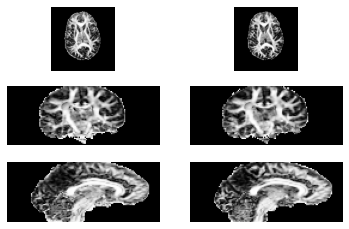

In [ ]:
import matplotlib.pyplot as plt
from dipy.core.histeq import histeq

sli = data.shape[2] // 2

# Axuial
plt.figure('Brain segmentation')
plt.subplot(3, 2, 1).set_axis_off()
plt.imshow(histeq(FA1[:,:,sli,0].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(3, 2, 2).set_axis_off()
plt.imshow(histeq(FA2[:,:,sli,0].astype('float')).T,
           cmap='gray', origin='lower')

# Coronal
plt.subplot(3, 2, 3).set_axis_off()
plt.imshow(histeq(FA1[:,64,:,0].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(3, 2, 4).set_axis_off()
plt.imshow(histeq(FA2[:,64,:,0].astype('float')).T,
           cmap='gray', origin='lower')

# Sagital
plt.subplot(3, 2, 5).set_axis_off()
plt.imshow(histeq(FA1[64,:,:,0].astype('float')).T,
           cmap='gray', origin='lower')

plt.subplot(3, 2, 6).set_axis_off()
plt.imshow(histeq(FA2[64,:,:,0].astype('float')).T,
           cmap='gray', origin='lower')

plt.savefig('sDTI_cDTI.png')
plt.show()

Si graficamos algunas pareja de valores de la __FA__ calculada con libreria dti y sin ella obtenemos la siguiente gráfica. Podemos notar que los puntos se concentran al rededor de la recta identidad por lo que el método implementado ofrece resultados  parecidos.

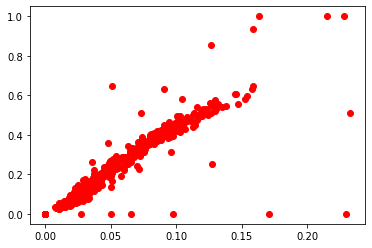

In [ ]:
FA1 = FA1 * mask
FA2 = FA2 * mask

plt.plot(
    FA1[13:43, 60:90, 28:29, :].astype('float').flatten(), 
    FA2[13:43, 60:90, 28:29, :].astype('float').flatten(), 
    'ro'
)
plt.show()

# Conclusiones y comentarios

En el presente proyecto, dado un conjunto de volumenes de RM ponderado en difusion de hidrógeno se ajusta un tensor de difusión __Gaussiano__ en cada voxel mediante mínimos cuadrádos y se calcula los eigenpares de la matriz indicida por este vector de difusión usando la factorización SVD de la matriz. 

Podemos notar que los resultados obtenidos con una implementación propia se parecen a los resultados obtenidos con la librería `dti` de `DIPY`. 

Los resultados se guardan en archivos en la misma carpeta del código.